# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531000,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232000,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956000,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477000,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252000,50.731510,0.405664,4,9.007982,13.296366
5,5,0.283079,28.750000,16.028999,26.066658,0.563075,5,9.739926,13.474633
6,6,0.257084,75.000000,8.438000,0.178269,0.000000,6,8.118750,13.295704
7,7,0.204954,37.125000,11.337000,38.425858,3.483478,7,8.496488,13.402612
8,8,0.500755,52.599998,17.586000,30.515917,0.527488,8,9.630793,12.942725
9,9,0.246689,96.400002,13.598000,34.000835,1.548348,9,10.366383,13.001889


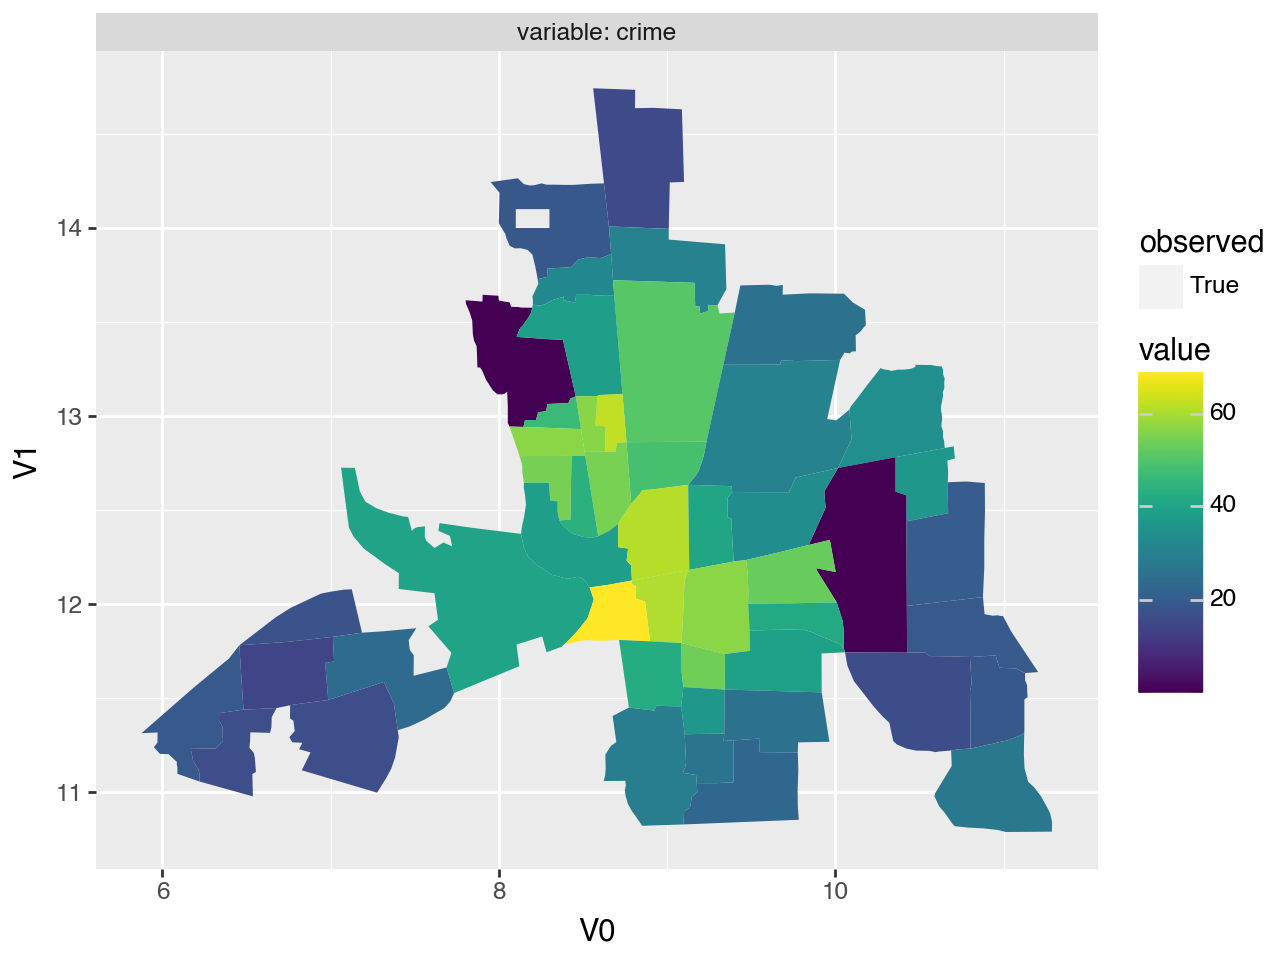

In [4]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [ ]:
df = columb

# standardizing makes it easier for the model
df["crime"] = (df["crime"] - df["crime"].mean()) / df["crime"].std()

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)

# initializing intercepts to sensible values
loc.intercept.value = df.crime.mean()
scale.intercept.value = jnp.log(df.crime.std())


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)


loc += tb.mrf(
    "district",
    k=40,  # using a low-rank MRF here, because we have only 1 observation per cluster.
    polys=polys,
    scale=gam.VarIGPrior(0.01, 0.01, 0.1),  # using a very uninformative prior
    factor_scale=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\beta_{0,\mu}$_value").value


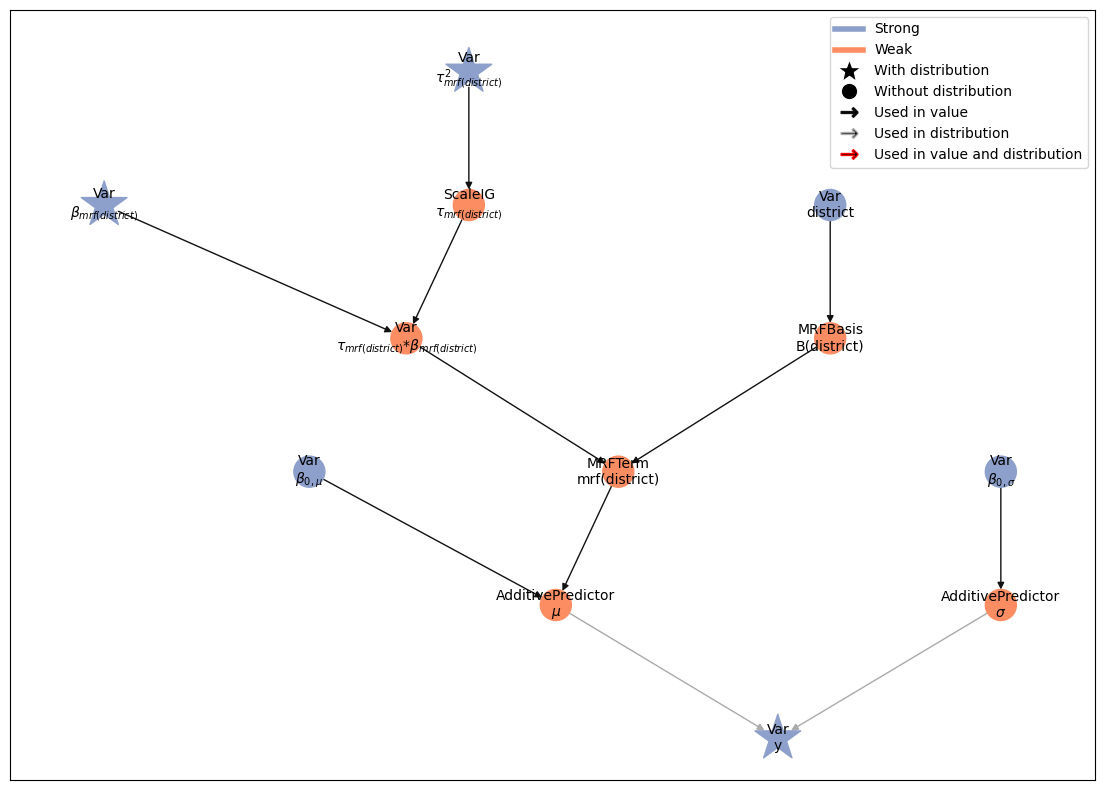

In [6]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau_{mrf(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.10chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:01<00:00,  7.42chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel      mean        sd    q_0.05  \
parameter                index                                            
$\beta_{0,\mu}$          ()     kernel_01 -0.003079  0.095987 -0.158935   
$\beta_{0,\sigma}$       ()     kernel_00 -0.431575  0.178699 -0.719217   
$\beta_{mrf(district)}$  (0,)   kernel_02 -0.823914  0.914538 -2.309317   
                         (1,)   kernel_02  0.009203  0.875150 -1.432152   
                         (2,)   kernel_02 -0.118835  0.859298 -1.517275   
                         (3,)   kernel_02 -0.051193  0.832060 -1.413940   
                         (4,)   kernel_02  0.078616  0.822506 -1.274265   
                         (5,)   kernel_02 -0.017135  0.835486 -1.399549   
                         (6,)   kernel_02  0.878452  0.880537 -0.624963   
                         (7,)   kernel_02 -0.305823  0.840743 -1.665211   
                         (8,)   kernel_02 -0.157621  0.804955 -1.452074   
                         (9,)   kernel_02 -0.275129  0.820116 -1.605335   
                         (10,)  kernel_02  0.565790  0.831676 -0.810789   
                         (11,)  kernel_02  0.515961  0.816493 -0.818030   
                         (12,)  kernel_02  1.390952  0.891849 -0.142347   
                         (13,)  kernel_02 -0.175309  0.807221 -1.477958   
                         (14,)  kernel_02  0.225638  0.798696 -1.085398   
                         (15,)  kernel_02  0.581311  0.805248 -0.753034   
                         (16,)  kernel_02  0.165759  0.802212 -1.158283   
                         (17,)  kernel_02  0.414818  0.776757 -0.872618   
                         (18,)  kernel_02 -0.257027  0.806633 -1.580195   
                         (19,)  kernel_02 -0.573808  0.802181 -1.863780   
                         (20,)  kernel_02  0.494327  0.774879 -0.760574   
                         (21,)  kernel_02  0.530656  0.778435 -0.786681   
                         (22,)  kernel_02  0.331553  0.765636 -0.937291   
                         (23,)  kernel_02  0.810183  0.772429 -0.471082   
                         (24,)  kernel_02 -0.338580  0.749813 -1.543202   
                         (25,)  kernel_02  0.488672  0.741357 -0.735522   
                         (26,)  kernel_02 -0.516721  0.711061 -1.638096   
                         (27,)  kernel_02 -0.795857  0.721048 -1.932622   
                         (28,)  kernel_02  0.370154  0.723415 -0.839020   
                         (29,)  kernel_02 -0.236379  0.685762 -1.320755   
                         (30,)  kernel_02  0.845481  0.684651 -0.290682   
                         (31,)  kernel_02  0.992265  0.652652 -0.094523   
                         (32,)  kernel_02 -0.807412  0.640372 -1.841112   
                         (33,)  kernel_02  1.206430  0.633348  0.164045   
                         (34,)  kernel_02  0.672337  0.560076 -0.246009   
                         (35,)  kernel_02 -1.434051  0.514868 -2.305065   
                         (36,)  kernel_02  1.453195  0.496113  0.719676   
                         (37,)  kernel_02 -0.433340  0.360576 -1.049348   
                         (38,)  kernel_02 -0.653223  0.284434 -1.157299   
$\tau_{mrf(district)}^2$ ()     kernel_03  3.904057  1.950130  1.134918   

                                   q_0.5    q_0.95  sample_size     ess_bulk  \
parameter                index                                                 
$\beta_{0,\mu}$          ()    -0.002995  0.155571         4000  4251.569585   
$\beta_{0,\sigma}$       ()    -0.435218 -0.140429         4000   624.512357   
$\beta_{mrf(district)}$  (0,)  -0.858455  0.704964         4000  2770.032726   
                         (1,)   0.001785  1.426830         4000  3433.854835   
                         (2,)  -0.124686  1.311182         4000  3460.052412   
                         (3,)  -0.044706  1.341858         4000  3775.071875   
                         (4,)   0.07423

## Plots

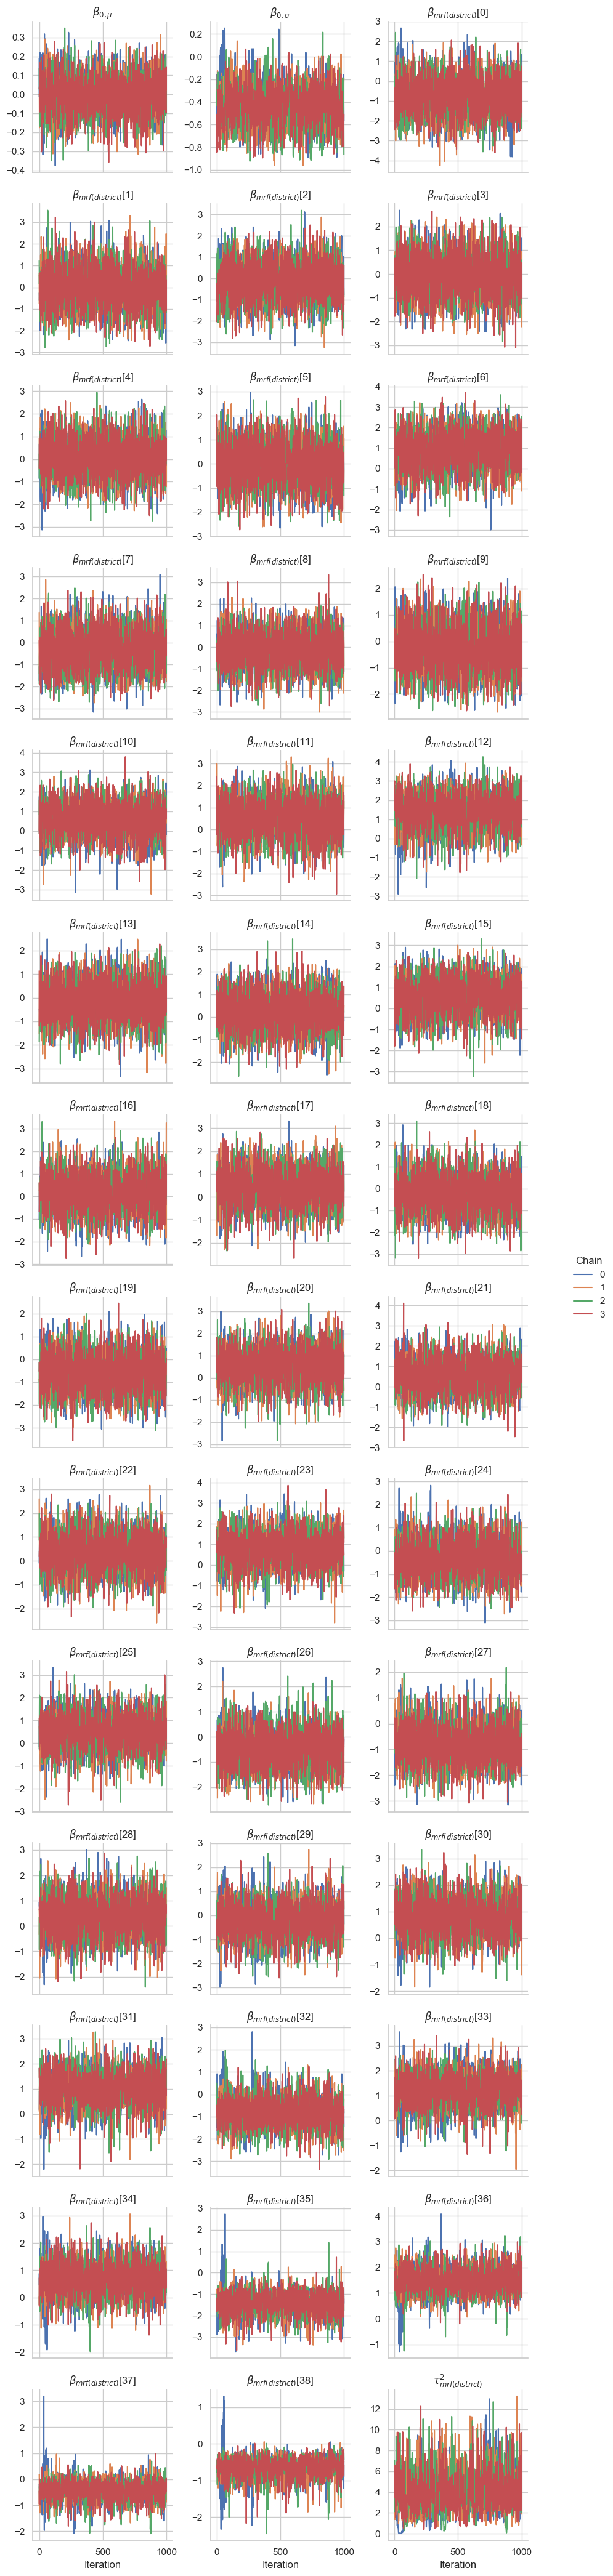

In [9]:
gs.plot_trace(results)

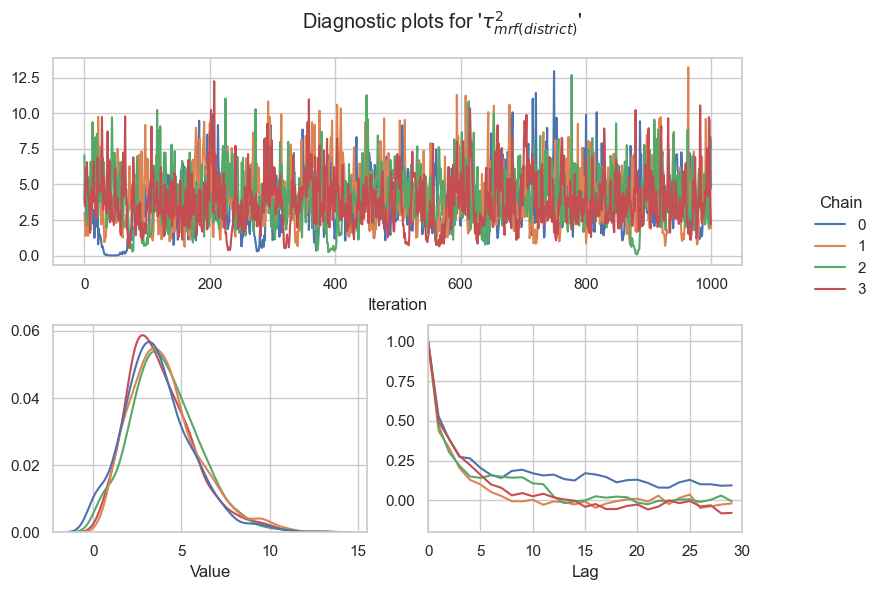

In [15]:
gs.plot_param(results, "$\\tau_{mrf(district)}^2$")

In [11]:
samples = results.get_posterior_samples()

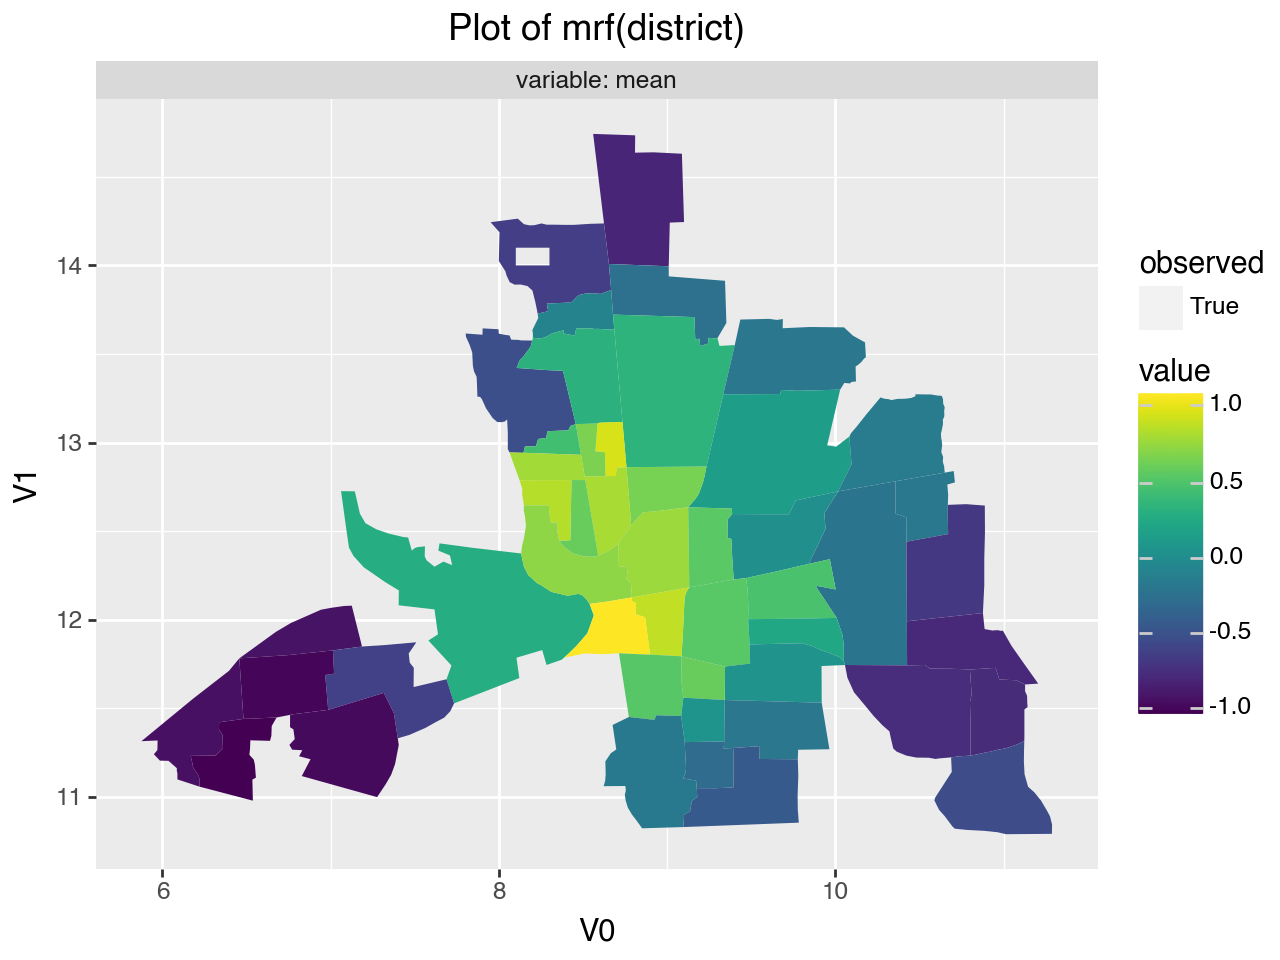

In [12]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
)

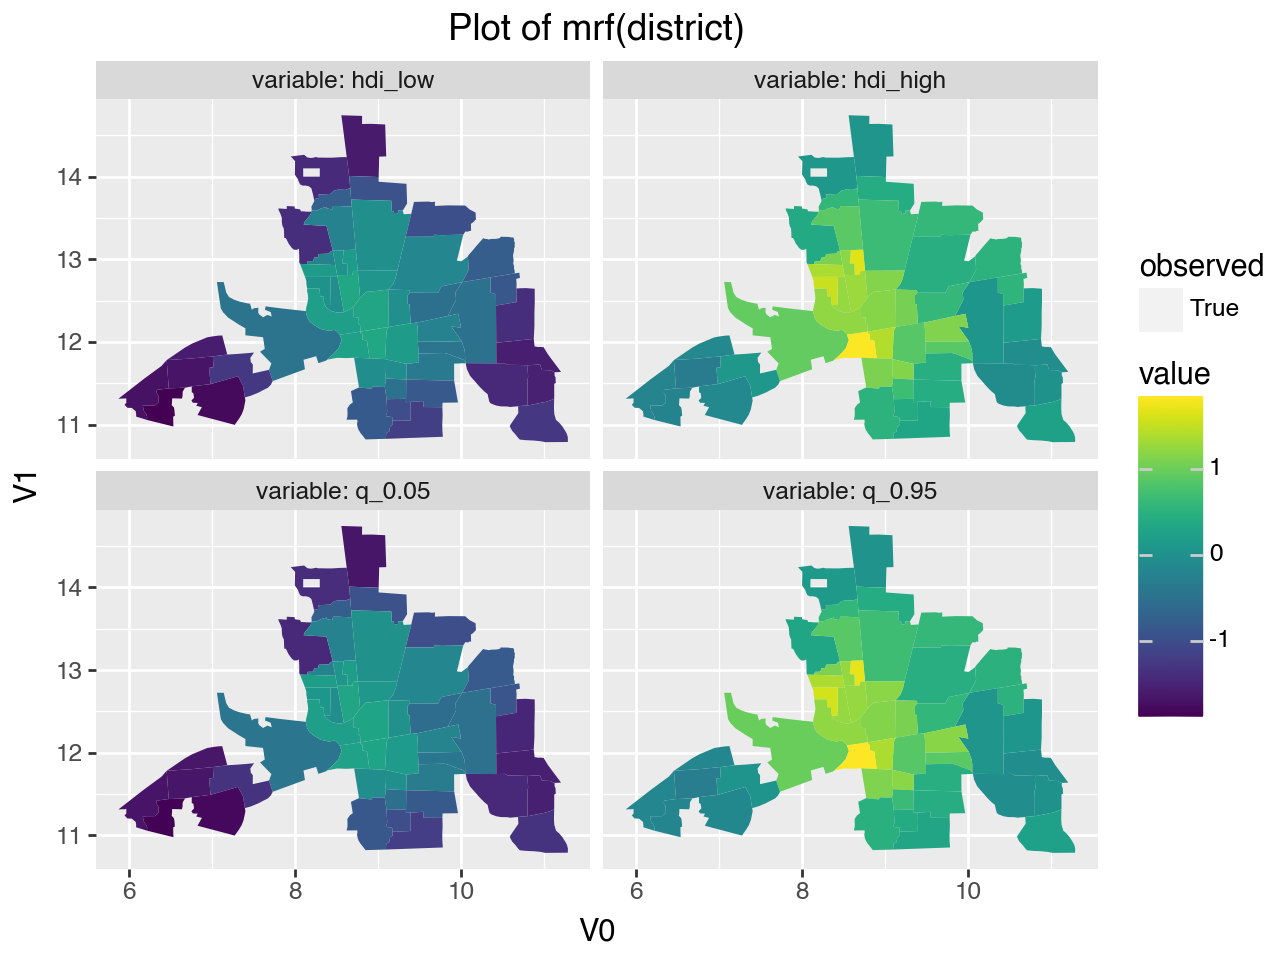

In [13]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # polys=polys, # since the term was created with polygons, no need to supply them
    which=["hdi_low", "hdi_high", "q_0.05", "q_0.95"],
)

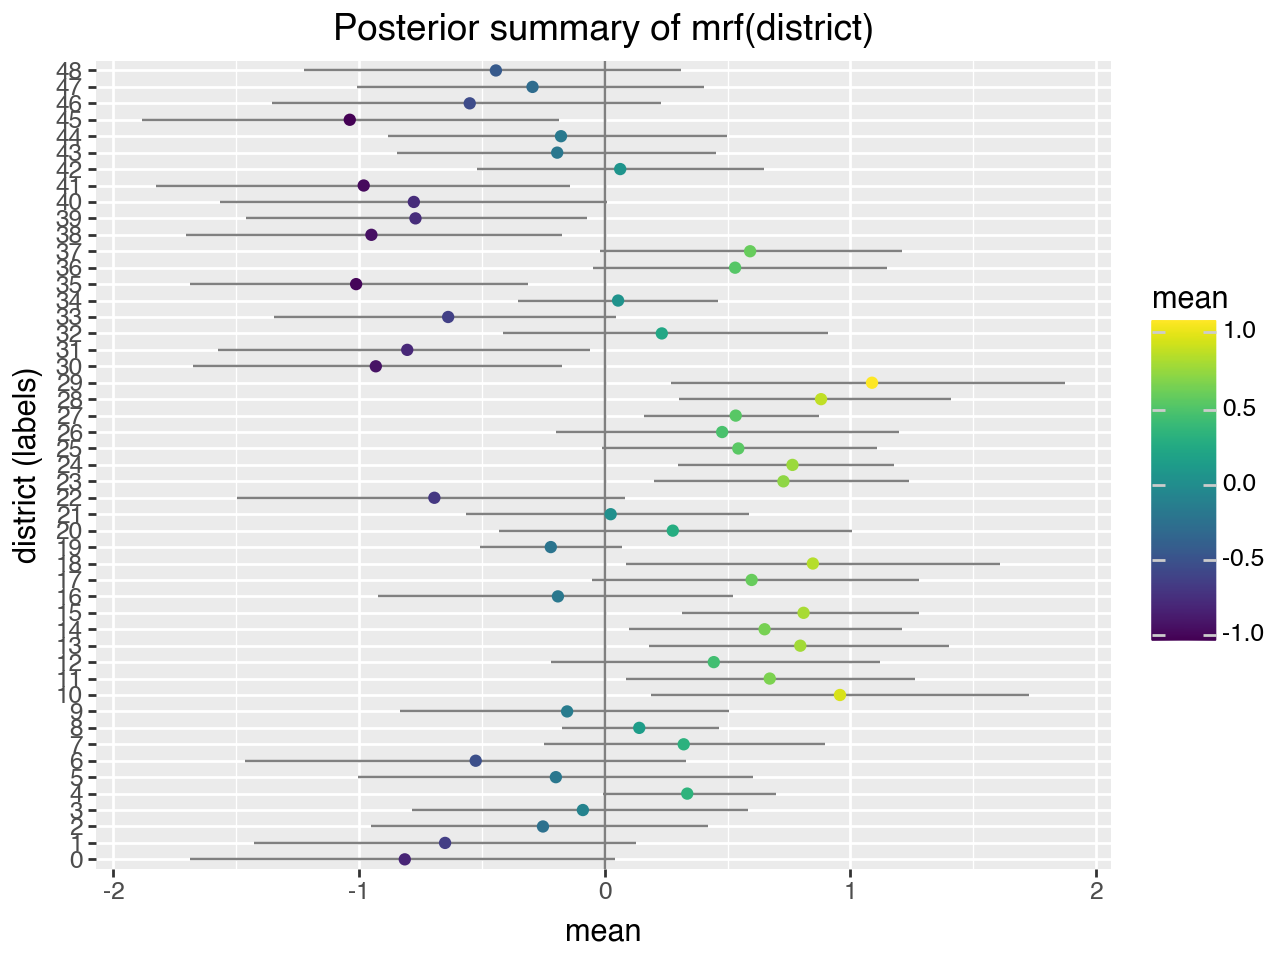

In [14]:
import plotnine as p9

gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    # labels=tb.bases.mappings["district"],
    ymin="q_0.05",
    ymax="q_0.95",
) + p9.aes(color="mean")